In [25]:
import ds_loader as dsl
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
from pathlib import Path
from meanAveragePrecision import computeMeanAveragePrecision
import numpy as np

In [26]:
class Config():
    batch_size = 32
    epochs = 20
    learn_rate = 0.0001
    CLASSES = 55
    DATABASE_FOLDER_TRAIN = str(Path("../../dataset/training/"))
    DATABASE_FOLDER_TEST = str(Path("../../dataset/testing/"))
    SAMPLING_RATE = 800
    #weight_decay = 0.001

In [27]:
dsl.get_dataset(save=True, folder=Config.DATABASE_FOLDER_TRAIN)
dsl.get_dataset(save=True, folder=Config.DATABASE_FOLDER_TEST)

array([[[[-2.50998068e+00, -1.11000001e+00, -3.23840380e-01, ...,
           1.09106445e+00, -1.02500000e+02,  1.50625000e+01],
         [ 9.19208527e+00,  9.73999977e+00, -1.18244357e-01, ...,
           5.54199219e-02, -1.12804878e+00, -3.37500000e+00],
         [ 4.19128448e-01, -2.39999995e-01,  3.51537280e-02, ...,
           2.10449219e-01, -4.58841476e+01, -2.43750000e+00]],

        [[-2.37585950e+00, -1.14999998e+00, -3.30231994e-01, ...,
           1.06880713e+00, -9.63932266e+01,  1.49811077e+01],
         [ 9.22322083e+00,  9.73999977e+00, -1.52332813e-01, ...,
           5.25721237e-02, -1.61434448e+00, -3.22979593e+00],
         [ 5.02954125e-01, -2.09999993e-01,  1.17179090e-02, ...,
           2.16013715e-01, -4.63027534e+01, -2.23833084e+00]],

        [[-2.12917256e+00, -1.17999995e+00, -3.39819372e-01, ...,
           1.02110338e+00, -8.30261536e+01,  1.47574720e+01],
         [ 9.42679691e+00,  9.72999954e+00, -1.71507582e-01, ...,
           4.59693410e-02, -2.7121

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [29]:
train_dl = dsl.get_dataloader(is_train=True, batch_size=Config.batch_size)
test_dl = dsl.get_dataloader(is_train=False, batch_size=Config.batch_size)

In [30]:
#define mode
model = mobilenet_v2(pretrained=True)

model.features[0][0] = nn.Conv2d(9, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=Config.CLASSES)

model.to(device)

# define optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=Config.learn_rate, weight_decay=Config.weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=Config.learn_rate)
# define loss function
loss_function = nn.CrossEntropyLoss()

next(model.parameters()).is_cuda

True

===> Epoch: 0 loss: 3.3663
===> Epoch: 1 loss: 2.6176
===> Epoch: 2 loss: 2.6290
===> Epoch: 3 loss: 2.7042
===> Epoch: 4 loss: 1.8554
===> Epoch: 5 loss: 1.5142
===> Epoch: 6 loss: 2.0101
===> Epoch: 7 loss: 1.5835
===> Epoch: 8 loss: 1.9213
===> Epoch: 9 loss: 1.3722
===> Epoch: 10 loss: 0.9603
===> Epoch: 11 loss: 1.0413
===> Epoch: 12 loss: 1.3740
===> Epoch: 13 loss: 0.7219
===> Epoch: 14 loss: 0.8354
===> Epoch: 15 loss: 1.9678
===> Epoch: 16 loss: 0.7480
===> Epoch: 17 loss: 1.2060
===> Epoch: 18 loss: 1.3391
===> Epoch: 19 loss: 0.9313


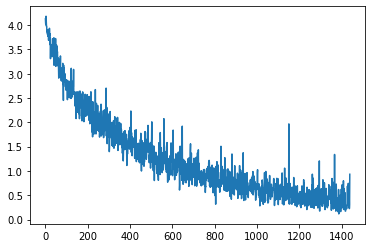

In [31]:
loss_ls_train = []
model.train()

for epoch in range(Config.epochs):
    for data, labels in train_dl:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        data = data.permute(0, 3, 1, 2)

        prediction = model(data)

        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()

        loss_ls_train.append(loss.data.item())

    print('===> Epoch: {} loss: {:.4f}'.format(epoch, loss.data.item()))

plt.plot(loss_ls_train)
plt.show()

In [32]:
#model = torch.load('/Users/falcolentzsch/Develope/MDS4AGT/krasses_model.pt',map_location=device)
# Start Evaluation
model.eval()
correct_pred = 0
num_pred = 0
map_sum = 0
count = 0

for data, label in test_dl:
    data, label = data.to(device), label.to(device)

    data = data.permute(0, 3, 1, 2)
    softmax_v = F.softmax(model(data))
    pred = torch.argmax(softmax_v, dim=1)

    num_pred += len(label)
    correct_pred = correct_pred + torch.eq(pred,label).sum().data.item()

    tmp_map, _ = computeMeanAveragePrecision(label.detach().cpu().numpy(), softmax_v.detach().cpu().numpy())
    map_sum += tmp_map
    count +=1

print('Number of correct predictions: ' + str(correct_pred))
print('Number of Predictions:' + str(num_pred))
print('Accuracy: ' + str(correct_pred/num_pred))
print('MAP: ' + str(map_sum/count))

<ipython-input-32-ea45365a205c>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_v = F.softmax(model(data))


Number of correct predictions: 1244
Number of Predictions:2288
Accuracy: 0.5437062937062938
MAP: 0.33144095809095436


In [19]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(9, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen